# Policy based RL
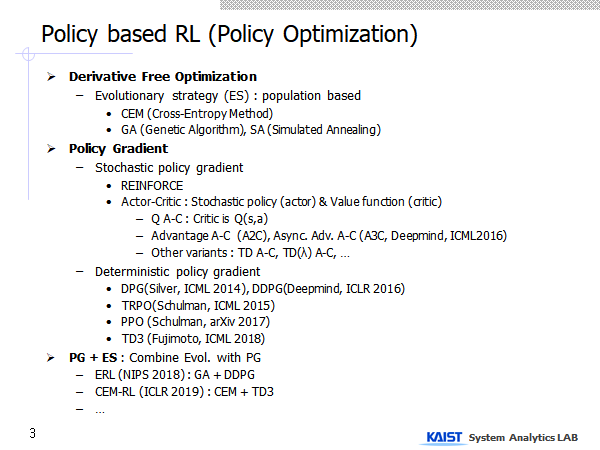

J(\theta) 
= \sum_{s \in \mathcal{S}} d^\pi(s) V^\pi(s) 
= \sum_{s \in \mathcal{S}} d^\pi(s) \sum_{a \in \mathcal{A}} \pi_\theta(a \vert s) Q^\pi(s, a)

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

## Reward definition function

- Default reward : +1 for each step
- We separate a reward function for reward modification later

In [2]:
def reward(obs, r):
    return np.float32(r)
#     return np.float32(r + 10*np.abs(obs[2]))

In [3]:
class MLP(torch.nn.Module):
    def __init__(self, lsize):
        super().__init__()
        self.layers = nn.ModuleList()
        self.n_layers = len(lsize) - 1
        for i in range(self.n_layers):
            self.layers.append(torch.nn.Linear(lsize[i], lsize[i+1]))
            # self.layers.append(nn.BatchNorm2d(lsize[i]))

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        for i in range(self.n_layers):
            x = self.layers[i](x)
            if i < self.n_layers-1:
                # x = torch.tanh(x)
                x = F.relu(x)
        return x  # softmax is done within F.cross_entropy
        # return F.softmax(x, dim=-1)


# REINFORCE algorithm

## REINFORCE agent

In [11]:
class AgentReinforce:
    def __init__(self, env):
        self.env = env
        self.dimState = env.observation_space.shape[0]
        self.dimAction = env.action_space.n
        self.gamma = 0.99
        self.tau = 1

#         lsize = [self.dimState, self.dimAction] # linear opolicy
        H = 256
        lsize = [self.dimState, H, self.dimAction]
        self.device = torch.device('cpu')
        self.actor = MLP(lsize).to(self.device)
        # self.optimizerA = optim.SGD(self.actor.parameters(), lr=0.01)
        self.optimizerA = optim.Adam(self.actor.parameters(), lr=0.001)
        # self.optimizerA = optim.Adam(self.actor.parameters(), lr=0.01, weight_decay=0.000001)
        self.lrSchedulerA = torch.optim.lr_scheduler.StepLR(self.optimizerA, step_size=10, gamma=0.9)

    def load(self, fn):
        self.actor.load_state_dict(torch.load(fn))
        
    def save(self, fn):
        torch.save(self.actor.state_dict(), fn)        
        
    def getAction(self, state):  # policy function
        q = self.actor(state) * self.tau
        p = F.softmax(q, dim=1)
        m = Categorical(p)
        a = m.sample()
        self.logProb = m.log_prob(a)
        a = a.item()
        self.sumProb += p[0,a].item()
#         print (self.sumProb)
        return a

    def computeReturns(self, rewards, finalValue):
        ret = []
        N = len(rewards)
        R = finalValue
        for t in reversed(range(0, N)):
            R = rewards[t] + self.gamma * R
#             R *= self.gamma ** t
            ret.insert(0, R)
        return ret

    def trainEpisode1(self, maxStep=200, render=False):
        LogP = []
        R = []
        masks = []
        obs = self.env.reset()
        s = torch.FloatTensor(obs).view(1,self.dimState).to(self.device)
        self.sumProb = 0

        ret = 0
        retMax = 0
        nStep = 0
        done = False
        while not done:
            nStep += 1
            if render:  self.env.render()
            a = self.getAction(s)  # action selection prob. is saved in self.logProb
            obs, r, done, info = self.env.step(a)
            r = reward(obs, r)
            ret += r
            sp = torch.FloatTensor(obs).view(1,self.dimState).to(self.device)

            LogP.append(self.logProb)
            R.append(torch.tensor([r], dtype=torch.float, device=self.device))
            s = sp
            if nStep >= maxStep:  
                break

        if done:
            finalValue = 0
        else:
            finalValue = r/(1-self.gamma)
        returns = self.computeReturns(R, finalValue)
        LogP = torch.cat(LogP)
        returns = torch.cat(returns)
        actorLoss = -(LogP * returns).mean()
        self.optimizerA.zero_grad()
        actorLoss.backward()
        self.optimizerA.step()
        if ret > retMax:  # new record
            retMax = ret
        self.lrSchedulerA.step()
        p = self.sumProb/nStep
        print (f"mean p = {p}, actor loss = {actorLoss.item()}, LR={self.optimizerA.param_groups[0]['lr']}")

        return ret


    def runMany(self, nEpisode=1000, maxStep=200):
        retHist = []

        i = 0
        max5 = 0
        while i < nEpisode:
            i += 1
            ret = self.trainEpisode1(maxStep=maxStep)
            retHist.append(ret)
            print (f"iteration = {i}, return = {ret}")

        plt.plot(retHist)
        plt.show()

        
    def runTest(self, maxStep=1000, render=True, tau=10):
        if tau is not None:
            tauSave = self.tau
            self.tau = tau
        
        obs = self.env.reset()
        done = False
        ret = 0
        nStep = 0
        while not done:
            if render:
                self.env.render()
            s = torch.FloatTensor(obs).view(1,self.dimState).to(self.device)
            a = self.getAction(s)
            obs, r, done, info = self.env.step(a)
            r = reward(obs, r)
            ret += r
            nStep += 1
            if nStep >= maxStep:  # 500 for v1
                break

        print(f"Test episode, return = {ret} in {nStep} steps")
            
        if tau is not None:
            self.tau = tauSave

## train AgentReinforce

mean p = 0.4954223449413593, actor loss = 12.386948585510254, LR=0.0005
iteration = 1, return = 39.0
mean p = 0.5216869208961725, actor loss = 5.448441982269287, LR=0.0005
iteration = 2, return = 16.0
mean p = 0.515499343474706, actor loss = 6.0776448249816895, LR=0.0005
iteration = 3, return = 18.0
mean p = 0.514158758852217, actor loss = 6.059064865112305, LR=0.0005
iteration = 4, return = 18.0
mean p = 0.5634579062461853, actor loss = 2.6695396900177, LR=0.0005
iteration = 5, return = 8.0
mean p = 0.5827374590767754, actor loss = 2.827824831008911, LR=0.0005
iteration = 6, return = 9.0
mean p = 0.5407348977667945, actor loss = 4.5952677726745605, LR=0.0005
iteration = 7, return = 14.0
mean p = 0.5563131630420685, actor loss = 6.396971702575684, LR=0.0005
iteration = 8, return = 20.0
mean p = 0.5357805639505386, actor loss = 4.071896553039551, LR=0.0005
iteration = 9, return = 12.0
mean p = 0.5073732661789861, actor loss = 9.503576278686523, LR=0.000475
iteration = 10, return = 29.0


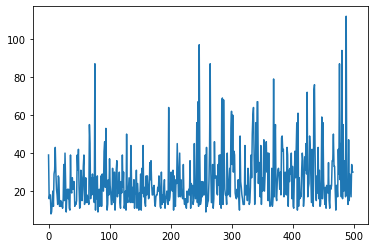

In [12]:
env = gym.make('CartPole-v0').unwrapped
agentR = AgentReinforce(env)
agentR.optimizerA = optim.Adam(agentR.actor.parameters(), lr=0.0005)
agentR.lrSchedulerA = torch.optim.lr_scheduler.StepLR(agentR.optimizerA, step_size=10, gamma=0.95)

agentR.runMany(nEpisode=500, maxStep=2500)

In [ ]:
agentR.runTest()
env.close()

## Actor-Critic  (Advantage Actor-Critic, A2C)

In [13]:
class AgentA2C(AgentReinforce):
    def __init__(self, env):
        super().__init__(env)
        self.prepareCritic()
        self.retMax = -9e49
        self.sumProb = 0

    def prepareCritic(self):
        H = 256
        lsize = [self.dimState, H, 1]
        self.critic = MLP(lsize).to(self.device)
        self.optimizerC = optim.Adam(self.critic.parameters(), lr=0.05)
        self.lrSchedulerC = torch.optim.lr_scheduler.StepLR(self.optimizerC, step_size=10, gamma=0.9)
        self.optimizerA = optim.Adam(self.actor.parameters(), lr=0.0001)
        # self.optimizerA = optim.Adam(self.actor.parameters(), lr=0.001, weight_decay=0.000001)
        self.lrSchedulerA = torch.optim.lr_scheduler.StepLR(self.optimizerA, step_size=10, gamma=0.9)
        
    def load(self, fn):
        super().load(fn+'A')
        self.critic.load_state_dict(torch.load(fn+'C'))
        
    def save(self, fn):
        super().save(fn+'A')
        torch.save(self.critic.state_dict(), fn+'C')              
        
    def updateAC(self, s, logP, r, sp, done):
        Vs = self.critic(s)
        with torch.no_grad():
            Vsp = self.critic(sp)
        target = r + ((1 - done) * self.gamma) * Vsp
        advantage = target - Vs
        actorLoss = -(logP * advantage.detach())  # backprop toward LogP only

        self.optimizerA.zero_grad()
        actorLoss.backward()
        self.optimizerA.step()
        # self.lrSchedulerA.step()
        # print (f"actor loss = {actorLoss.item()}, LR={self.optimizerA.param_groups[0]['lr']}")

        criticLoss = (advantage*advantage)   # backprop toward advantages
        self.optimizerC.zero_grad()
        criticLoss.backward()
        self.optimizerC.step()
        # self.lrSchedulerC.step()
        # print (f"target={target.item()}, Vs={Vs.item()}, pi(a)={np.exp(logP.item()):.2f}, actor loss = {actorLoss.item()}, critic loss = {criticLoss.item()}")


    def trainEpisode1(self, maxStep=200, render=False):
        obs = self.env.reset()
        s = torch.FloatTensor(obs).view(1,self.dimState).to(self.device)
        self.sumProb = 0

        ret = 0
        nStep = 0
        done = False
        while not done:
            nStep += 1
            if render:  self.env.render()
            a = self.getAction(s)
            obs, r, done, info = self.env.step(a)
            r = reward(obs, r)
            ret += r
            sp = torch.FloatTensor(obs).view(1,self.dimState).to(self.device)
            self.updateAC(s, self.logProb, r, sp, done)
            s = sp
            if nStep >= maxStep:  # 500 for v1
                break

        if ret > self.retMax:
            self.save("saved/Cartpole-AC")
            self.retMax = ret
        print (f'mean prob = {self.sumProb / nStep}')
        return ret


mean prob = 0.5118336998499357
iteration = 1, return = 46.965691566467285
mean prob = 0.5534086146137931
iteration = 2, return = 21.73797369003296
mean prob = 0.5468174467484156
iteration = 3, return = 22.472848296165466
mean prob = 0.5215165326992671
iteration = 4, return = 50.36873817443848
mean prob = 0.5042319685220719
iteration = 5, return = 23.003286004066467
mean prob = 0.5252848545710246
iteration = 6, return = 26.648833394050598
mean prob = 0.5299146711826325
iteration = 7, return = 21.79243278503418
mean prob = 0.5097793607876219
iteration = 8, return = 51.475913643836975
mean prob = 0.5192103226979573
iteration = 9, return = 28.739644289016724
mean prob = 0.5016787087917328
iteration = 10, return = 43.205424308776855
mean prob = 0.510005744440215
iteration = 11, return = 26.927393913269043
mean prob = 0.4969190205846514
iteration = 12, return = 56.94633901119232
mean prob = 0.49482416636065435
iteration = 13, return = 33.43089687824249
mean prob = 0.4923486824219043
iteratio

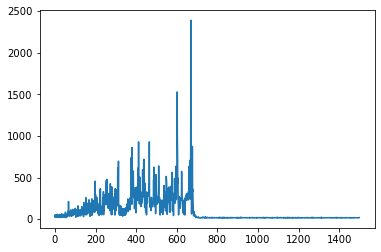

In [124]:
env = gym.make('CartPole-v0').unwrapped
agentAC = AgentAC(env)
agentAC.runMany(nEpisode=1500, maxStep=1500)

In [123]:
# env = gym.make('CartPole-v0').unwrapped
agentAC = AgentAC(env)
agentAC.load('saved/Cartpole-AC')
agentAC.runTest(tau=10)
env.close()

Test episode, return = 333.4120273590088 in 244 steps


In [ ]:
env.close()